In [9]:
# Cell 1: Import required libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully")
print(f"✓ TensorFlow version: {tf.__version__}")

✓ All libraries imported successfully
✓ TensorFlow version: 2.19.0


In [10]:
# Cell 2: Load the transformed datasets
print("="*50)
print("LOADING CNN-LSTM READY DATASET")
print("="*50)

# Load the datasets
df_transformed = pd.read_csv('cnn_lstm_ready_dataset.csv')
target_data = pd.read_csv('target_data_for_sequences.csv')

print(f"✓ Transformed data shape: {df_transformed.shape}")
print(f"✓ Target data shape: {target_data.shape}")
print(f"✓ Transformed data columns: {len(df_transformed.columns)} features")
print(f"✓ Target data columns: {len(target_data.columns)} target variables")
print(df_transformed.columns)
# Display first few rows
print(f"\nFirst 3 rows of transformed data:")
print(df_transformed.head(3))

LOADING CNN-LSTM READY DATASET
✓ Transformed data shape: (1458, 65)
✓ Target data shape: (1458, 4)
✓ Transformed data columns: 65 features
✓ Target data columns: 4 target variables
Index(['Year', 'CheckTotal', 'is_zero', 'IsRamadan', 'IsEid', 'IsPreRamadan',
       'IsPostRamadan', 'IsLast10Ramadan', 'IsDSF', 'IsSummerEvent',
       'IsNationalDay', 'IsNewYear', 'IsMarathon', 'IsGITEX', 'IsAirshow',
       'IsFoodFestival', 'IsPreEvent', 'IsPostEvent', 'Month_sin', 'Month_cos',
       'DayOfWeek_sin', 'DayOfWeek_cos', 'Meal_Breakfast', 'Meal_Dinner',
       'Meal_Lunch', 'Event_Dubai-Airshow', 'Event_Dubai-Food-Festival',
       'Event_Dubai-Marathon', 'Event_Dubai-Shopping-Festival',
       'Event_Dubai-Summer-Surprises', 'Event_Eid-Adha', 'Event_Flag-Day',
       'Event_GITEX-Technology-Week', 'Event_New-Year-Celebrations',
       'Event_Normal', 'Event_Post-Dubai-Airshow', 'Event_Post-Dubai-Marathon',
       'Event_Post-Eid-Adha', 'Event_Post-Flag-Day',
       'Event_Post-GITEX-Tech

In [11]:
def create_sequences_for_cnn_lstm(df_transformed, target_data, sequence_length=30, forecast_horizon=7):
    """
    Create sequences for CNN-LSTM training from loaded CSV files
    """
    print("="*50)
    print("CREATING SEQUENCES FOR CNN-LSTM")
    print("="*50)
    
    # Parameters
    SEQ_LENGTH = sequence_length  # Look back 30 days
    FORECAST_HORIZON = forecast_horizon  # Predict next 7 days
    
    # Sort by date to ensure proper sequence order
    df_transformed_sorted = df_transformed.sort_values('Date').reset_index(drop=True)
    target_data_sorted = target_data.sort_values('Date').reset_index(drop=True)
    
    # Pivot target data to wide format
    target_pivot = target_data_sorted.pivot_table(
        index='Date', 
        columns=['RevenueCenterName', 'MealPeriod'], 
        values='CheckTotal', 
        fill_value=0
    ).reset_index()
    
    # Create column names for revenue streams
    target_pivot.columns = ['Date'] + [f"{col[0]}_{col[1]}" for col in target_pivot.columns[1:]]
    
    # Ensure same date range
    common_dates = set(df_transformed_sorted['Date']).intersection(set(target_pivot['Date']))
    df_transformed_sorted = df_transformed_sorted[df_transformed_sorted['Date'].isin(common_dates)].reset_index(drop=True)
    target_pivot = target_pivot[target_pivot['Date'].isin(common_dates)].reset_index(drop=True)
    
    # Remove Date column from features
    feature_columns = [col for col in df_transformed_sorted.columns if col != 'Date']
    features = df_transformed_sorted[feature_columns].values
    
    # Target columns (revenue targets)
    target_columns = [col for col in target_pivot.columns if col != 'Date']
    targets = target_pivot[target_columns].values
    
    print(f"✓ Feature shape: {features.shape}")
    print(f"✓ Target shape: {targets.shape}")
    print(f"✓ Number of feature columns: {len(feature_columns)}")
    print(f"✓ Number of target columns: {len(target_columns)}")
    print(f"✓ Target columns: {target_columns}")
    print(f"✓ Sequence length: {SEQ_LENGTH} days")
    print(f"✓ Forecast horizon: {FORECAST_HORIZON} days")
    
    # Create sequences
    X, y = [], []
    
    for i in range(SEQ_LENGTH, len(features) - FORECAST_HORIZON + 1):
        # Features: past 30 days
        X.append(features[i-SEQ_LENGTH:i])
        
        # Targets: next 7 days
        y.append(targets[i:i+FORECAST_HORIZON])
    
    X = np.array(X)
    y = np.array(y)
    
    print(f"✓ Final X shape: {X.shape}")  # (samples, 30, features)
    print(f"✓ Final y shape: {y.shape}")  # (samples, 7, revenue_targets)
    print(f"✓ Total sequences created: {len(X)}")
    
    return X, y, feature_columns, target_columns

In [12]:
# Cell 3A: Target Normalization Functions
from sklearn.preprocessing import StandardScaler
import joblib

def normalize_targets(y_train, y_test, save_scaler=True):
    """
    Normalize target values for better training stability
    """
    print("="*50)
    print("NORMALIZING TARGET VALUES")
    print("="*50)
    
    # Original data info
    print(f"📊 Original target ranges:")
    print(f"  y_train: ${y_train.min():.2f} - ${y_train.max():.2f}")
    print(f"  y_test: ${y_test.min():.2f} - ${y_test.max():.2f}")
    
    # Reshape for normalization: (samples, days, streams) -> (samples*days, streams)
    original_train_shape = y_train.shape
    original_test_shape = y_test.shape
    
    y_train_reshaped = y_train.reshape(-1, y_train.shape[-1])  # (samples*days, 3)
    y_test_reshaped = y_test.reshape(-1, y_test.shape[-1])     # (samples*days, 3)
    
    print(f"✓ Reshaped for scaling:")
    print(f"  y_train: {original_train_shape} -> {y_train_reshaped.shape}")
    print(f"  y_test: {original_test_shape} -> {y_test_reshaped.shape}")
    
    # Fit scaler on training data only
    target_scaler = StandardScaler()
    y_train_normalized = target_scaler.fit_transform(y_train_reshaped)
    y_test_normalized = target_scaler.transform(y_test_reshaped)
    
    # Reshape back to original format
    y_train_normalized = y_train_normalized.reshape(original_train_shape)
    y_test_normalized = y_test_normalized.reshape(original_test_shape)
    
    print(f"✓ Normalized target ranges:")
    print(f"  y_train: {y_train_normalized.min():.3f} - {y_train_normalized.max():.3f}")
    print(f"  y_test: {y_test_normalized.min():.3f} - {y_test_normalized.max():.3f}")
    print(f"  Mean: {y_train_normalized.mean():.3f}, Std: {y_train_normalized.std():.3f}")
    
    # Save scaler for later denormalization
    if save_scaler:
        joblib.dump(target_scaler, 'target_scaler.pkl')
        print(f"✅ Target scaler saved to 'target_scaler.pkl'")
    
    return y_train_normalized, y_test_normalized, target_scaler

def denormalize_predictions(predictions_normalized, target_scaler):
    """
    Convert normalized predictions back to actual dollar amounts
    """
    original_shape = predictions_normalized.shape
    
    # Reshape for denormalization
    pred_reshaped = predictions_normalized.reshape(-1, predictions_normalized.shape[-1])
    
    # Denormalize
    pred_actual = target_scaler.inverse_transform(pred_reshaped)
    
    # Reshape back
    pred_actual = pred_actual.reshape(original_shape)
    
    return pred_actual

print("✅ Target normalization functions defined")

✅ Target normalization functions defined


In [13]:
# Cell 4: Corrected - Handle data without Date column in features
def clean_and_prepare_data_fixed(df_transformed, target_data):
    """
    Clean dataframes when features don't have Date column
    """
    print("="*50)
    print("CLEANING AND PREPARING DATA FOR CNN-LSTM")
    print("="*50)
    
    # Step 1: Check original data
    print("Original data info:")
    print(f"df_transformed shape: {df_transformed.shape}")
    print(f"df_transformed columns: {list(df_transformed.columns)}")
    print(f"target_data shape: {target_data.shape}")
    print(f"target_data columns: {list(target_data.columns)}")
    
    # Check if data is already aligned by length
    if len(df_transformed) == len(target_data):
        print("✓ Data lengths match - assuming already aligned by row index")
        
        # Step 2: Pivot target data from long to wide format
        print("\n🔄 Pivoting target data to wide format...")
        
        # Add row index to help with pivoting
        target_with_index = target_data.copy()
        target_with_index['row_index'] = target_with_index.index
        
        # Create a day identifier (since we know there are 3 meal periods per day)
        target_with_index['day_id'] = target_with_index['row_index'] // 3
        
        target_pivot = target_with_index.pivot_table(
            index='day_id', 
            columns='MealPeriod', 
            values='CheckTotal', 
            fill_value=0
        ).reset_index()
        
        print(f"✓ Pivoted target shape: {target_pivot.shape}")
        print(f"✓ Pivoted target columns: {list(target_pivot.columns)}")
        
        # Step 3: Aggregate features to day level (average of 3 meal periods per day)
        print("\n📊 Aggregating features to day level...")
        
        # Add day_id to features
        df_features_with_day = df_transformed.copy()
        df_features_with_day['day_id'] = df_features_with_day.index // 3
        
        # Aggregate features by day (mean of the 3 meal periods)
        df_features_daily = df_features_with_day.groupby('day_id').mean().reset_index()
        df_features_daily = df_features_daily.drop('day_id', axis=1)
        
        print(f"✓ Aggregated features shape: {df_features_daily.shape}")
        
        # Step 4: Align the data
        target_values = target_pivot.drop('day_id', axis=1)
        
        # Ensure same number of rows
        min_rows = min(len(df_features_daily), len(target_values))
        df_features_final = df_features_daily.iloc[:min_rows]
        target_values_final = target_values.iloc[:min_rows]
        
        print(f"✓ Final aligned shapes:")
        print(f"Features: {df_features_final.shape}")
        print(f"Targets: {target_values_final.shape}")
        
    else:
        raise ValueError(f"Data length mismatch: features={len(df_transformed)}, targets={len(target_data)}")
    
    # Step 5: Clean data types and handle missing values
    print("\n🧹 Cleaning data types...")
    
    # Features: ensure all numeric
    df_features_clean = df_features_final.select_dtypes(include=[np.number])
    df_features_clean = df_features_clean.fillna(0).astype(np.float32)
    
    # Targets: ensure all numeric
    df_targets_clean = target_values_final.fillna(0).astype(np.float32)
    
    print(f"✅ Final cleaned data:")
    print(f"Features shape: {df_features_clean.shape}")
    print(f"Targets shape: {df_targets_clean.shape}")
    print(f"Target columns: {list(df_targets_clean.columns)}")
    print(f"Data lengths match: {len(df_features_clean) == len(df_targets_clean)}")
    
    return df_features_clean, df_targets_clean

def create_sequences_for_cnn_lstm_corrected(df_features, df_targets, sequence_length=30, forecast_horizon=7):
    """
    Create sequences from properly aligned and cleaned data
    """
    print("\n" + "="*50)
    print("CREATING SEQUENCES FOR CNN-LSTM")
    print("="*50)
    
    # Parameters
    SEQ_LENGTH = sequence_length
    FORECAST_HORIZON = forecast_horizon
    
    # Convert to arrays
    features = df_features.values
    targets = df_targets.values
    feature_columns = df_features.columns.tolist()
    target_columns = df_targets.columns.tolist()
    
    print(f"✓ Feature shape: {features.shape}")
    print(f"✓ Target shape: {targets.shape}")
    print(f"✓ Sequence length: {SEQ_LENGTH} days")
    print(f"✓ Forecast horizon: {FORECAST_HORIZON} days")
    print(f"✓ Target columns: {target_columns}")
    
    # Verify we have enough data
    min_data_needed = SEQ_LENGTH + FORECAST_HORIZON
    if len(features) < min_data_needed:
        raise ValueError(f"Not enough data. Need at least {min_data_needed} rows, got {len(features)}")
    
    # Create sequences
    X, y = [], []
    
    for i in range(SEQ_LENGTH, len(features) - FORECAST_HORIZON + 1):
        # Features: past SEQ_LENGTH days
        X.append(features[i-SEQ_LENGTH:i])
        
        # Targets: next FORECAST_HORIZON days
        y.append(targets[i:i+FORECAST_HORIZON])
    
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    
    print(f"✓ Final X shape: {X.shape}")  # (samples, sequence_length, features)
    print(f"✓ Final y shape: {y.shape}")  # (samples, forecast_horizon, revenue_streams)
    print(f"✓ X dtype: {X.dtype}")
    print(f"✓ y dtype: {y.dtype}")
    print(f"✓ Total sequences created: {len(X)}")
    
    # Show example of what each dimension means
    print(f"\n📊 Shape interpretation:")
    print(f"X: ({X.shape[0]} sequences, {X.shape[1]} days history, {X.shape[2]} features)")
    print(f"y: ({y.shape[0]} sequences, {y.shape[1]} days forecast, {y.shape[2]} revenue streams)")
    
    return X, y, feature_columns, target_columns

# Execute the corrected pipeline
try:
    # Step 1: Clean and prepare data without Date column dependency
    df_features_clean, df_targets_clean = clean_and_prepare_data_fixed(df_transformed, target_data)
    
    # Step 2: Create sequences
    X, y, feature_cols, target_cols = create_sequences_for_cnn_lstm_corrected(
        df_features_clean, df_targets_clean
    )
    
    print(f"\n🎉 SUCCESS! Sequences created successfully!")
    print(f"✓ Input sequences (X): {X.shape}")
    print(f"✓ Output sequences (y): {y.shape}")
    print(f"✓ Feature columns: {len(feature_cols)}")
    print(f"✓ Target columns: {target_cols}")
    print(f"✓ Data types: X={X.dtype}, y={y.dtype}")
    
except Exception as e:
    print(f"❌ Error: {e}")
    import traceback
    traceback.print_exc()

CLEANING AND PREPARING DATA FOR CNN-LSTM
Original data info:
df_transformed shape: (1458, 65)
df_transformed columns: ['Year', 'CheckTotal', 'is_zero', 'IsRamadan', 'IsEid', 'IsPreRamadan', 'IsPostRamadan', 'IsLast10Ramadan', 'IsDSF', 'IsSummerEvent', 'IsNationalDay', 'IsNewYear', 'IsMarathon', 'IsGITEX', 'IsAirshow', 'IsFoodFestival', 'IsPreEvent', 'IsPostEvent', 'Month_sin', 'Month_cos', 'DayOfWeek_sin', 'DayOfWeek_cos', 'Meal_Breakfast', 'Meal_Dinner', 'Meal_Lunch', 'Event_Dubai-Airshow', 'Event_Dubai-Food-Festival', 'Event_Dubai-Marathon', 'Event_Dubai-Shopping-Festival', 'Event_Dubai-Summer-Surprises', 'Event_Eid-Adha', 'Event_Flag-Day', 'Event_GITEX-Technology-Week', 'Event_New-Year-Celebrations', 'Event_Normal', 'Event_Post-Dubai-Airshow', 'Event_Post-Dubai-Marathon', 'Event_Post-Eid-Adha', 'Event_Post-Flag-Day', 'Event_Post-GITEX-Technology-Week', 'Event_Post-New-Year-Celebrations', 'Event_Post-Ramadan-Recovery', 'Event_Post-Ramadan-Week1', 'Event_Post-Summer-Event', 'Event_Pre

In [14]:
print(X)
print("----------------------------------------------------------")
print(y)

[[[-0.5757663   0.6442341  -0.08310281 ... -0.3115533  -2.6150928
    4.957716  ]
  [-0.5757663   0.20041224 -0.08310281 ... -0.3115533   0.38239563
   -0.20170578]
  [-0.5757663   0.10293791 -0.08310281 ... -0.3115533   0.38239563
   -0.20170578]
  ...
  [-0.5757663   0.01185533 -0.08310281 ... -0.3115533   0.38239563
   -0.20170578]
  [-0.5757663   0.11598377 -0.08310281 ... -0.3115533   0.38239563
   -0.20170578]
  [-0.5757663  -0.17047678 -0.08310281 ... -0.3115533   0.38239563
   -0.20170578]]

 [[-0.5757663   0.20041224 -0.08310281 ... -0.3115533   0.38239563
   -0.20170578]
  [-0.5757663   0.10293791 -0.08310281 ... -0.3115533   0.38239563
   -0.20170578]
  [-0.5757663   0.44010323 -0.08310281 ... -0.3115533   0.38239563
   -0.20170578]
  ...
  [-0.5757663   0.11598377 -0.08310281 ... -0.3115533   0.38239563
   -0.20170578]
  [-0.5757663  -0.17047678 -0.08310281 ... -0.3115533   0.38239563
   -0.20170578]
  [-0.5757663   0.15700552 -0.08310281 ... -0.3115533   0.38239563
   -0.2

In [15]:
# Cell 5: Train-Test Split with clean data
print("="*30)
print("TRAIN-TEST SPLIT")
print("="*30)

# Time-based split (80% train, 20% test)
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"✓ Training sequences: {X_train.shape[0]}")
print(f"✓ Testing sequences: {X_test.shape[0]}")
print(f"✓ Input shape per sample: {X_train.shape[1:]}")
print(f"✓ Output shape per sample: {y_train.shape[1:]}")

# Verify data types
print(f"✓ X_train dtype: {X_train.dtype}")
print(f"✓ y_train dtype: {y_train.dtype}")
print(f"✓ X_test dtype: {X_test.dtype}")
print(f"✓ y_test dtype: {y_test.dtype}")

# Check for any problematic values
print(f"\n✓ Data quality check:")
print(f"X_train NaN count: {np.isnan(X_train).sum()}")
print(f"y_train NaN count: {np.isnan(y_train).sum()}")
print(f"X_train Inf count: {np.isinf(X_train).sum()}")
print(f"y_train Inf count: {np.isinf(y_train).sum()}")

print(f"\n✅ Data is ready for training!")

TRAIN-TEST SPLIT
✓ Training sequences: 360
✓ Testing sequences: 90
✓ Input shape per sample: (30, 65)
✓ Output shape per sample: (7, 3)
✓ X_train dtype: float32
✓ y_train dtype: float32
✓ X_test dtype: float32
✓ y_test dtype: float32

✓ Data quality check:
X_train NaN count: 0
y_train NaN count: 0
X_train Inf count: 0
y_train Inf count: 0

✅ Data is ready for training!


In [16]:
# Cell 6: Define CNN-LSTM model architecture
def build_cnn_lstm_model(input_shape, output_shape):
    """
    Build CNN-LSTM hybrid model for hotel revenue forecasting
    """
    print(f"✓ Building model with input shape: {input_shape}")
    print(f"✓ Output shape: {output_shape}")
    
    model = Sequential([
        # CNN layers for feature extraction
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape, name='conv1d_1'),
        Conv1D(filters=64, kernel_size=3, activation='relu', name='conv1d_2'),
        MaxPooling1D(pool_size=2, name='maxpool_1'),
        Dropout(0.2, name='dropout_1'),
        
        # More CNN layers
        Conv1D(filters=32, kernel_size=3, activation='relu', name='conv1d_3'),
        MaxPooling1D(pool_size=2, name='maxpool_2'),
        Dropout(0.2, name='dropout_2'),
        
        # LSTM layers for temporal patterns
        LSTM(100, return_sequences=True, name='lstm_1'),
        Dropout(0.3, name='dropout_3'),
        LSTM(50, return_sequences=False, name='lstm_2'),
        Dropout(0.3, name='dropout_4'),
        
        # Dense layers for final prediction
        Dense(100, activation='relu', name='dense_1'),
        Dropout(0.2, name='dropout_5'),
        Dense(np.prod(output_shape), activation='linear', name='dense_output'),
    ])
    
    # Reshape output to (forecast_days, revenue_streams)
    model.add(tf.keras.layers.Reshape(output_shape, name='reshape_output'))
    
    return model

print("✓ Model building function defined")

✓ Model building function defined


In [17]:
# Cell 6A: Apply Target Normalization
print("="*40)
print("APPLYING TARGET NORMALIZATION")
print("="*40)

# Store original targets for comparison
y_train_original = y_train.copy()
y_test_original = y_test.copy()

# Apply normalization
y_train_norm, y_test_norm, target_scaler = normalize_targets(y_train, y_test, save_scaler=True)

# Update variables for training
y_train = y_train_norm
y_test = y_test_norm

print(f"✅ Target normalization applied!")
print(f"✅ Training will use normalized targets")
print(f"✅ Original targets preserved for comparison")

# Show the difference
print(f"\n📊 Comparison:")
print(f"Original y_train range: ${y_train_original.min():.2f} - ${y_train_original.max():.2f}")
print(f"Normalized y_train range: {y_train.min():.3f} - {y_train.max():.3f}")

APPLYING TARGET NORMALIZATION
NORMALIZING TARGET VALUES
📊 Original target ranges:
  y_train: $5.00 - $10052.50
  y_test: $66.00 - $9657.00
✓ Reshaped for scaling:
  y_train: (360, 7, 3) -> (2520, 3)
  y_test: (90, 7, 3) -> (630, 3)
✓ Normalized target ranges:
  y_train: -1.588 - 9.795
  y_test: -1.334 - 9.494
  Mean: -0.000, Std: 1.000
✅ Target scaler saved to 'target_scaler.pkl'
✅ Target normalization applied!
✅ Training will use normalized targets
✅ Original targets preserved for comparison

📊 Comparison:
Original y_train range: $5.00 - $10052.50
Normalized y_train range: -1.588 - 9.795


In [18]:
# Cell 7: Build and compile the model
print("="*30)
print("BUILDING MODEL")
print("="*30)

# Define input and output shapes
input_shape = (X_train.shape[1], X_train.shape[2])  # (30, features)
output_shape = (y_train.shape[1], y_train.shape[2])  # (7, revenue_streams)

# Build model
model = build_cnn_lstm_model(input_shape, output_shape)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

print("\n" + "="*30)
print("MODEL ARCHITECTURE")
print("="*30)
model.summary()

# Count parameters
total_params = model.count_params()
print(f"\n✓ Total parameters: {total_params:,}")

BUILDING MODEL
✓ Building model with input shape: (30, 65)
✓ Output shape: (7, 3)



MODEL ARCHITECTURE


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 28, 64)         │        12,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 26, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_1 (MaxPooling1D)        │ (None, 13, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 13, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 11, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_2 (MaxPooling1D)        │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 5, 100)         │        53,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 5, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │         5,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_output (Dense)            │ (None, 21)             │         2,121 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_output (Reshape)        │ (None, 7, 3)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,693 (475.36 KB)

 Trainable params: 121,693 (475.36 KB)

 Non-trainable params: 0 (0.00 B)


✓ Total parameters: 121,693


In [19]:
# Cell 8: Setup training callbacks
print("="*30)
print("TRAINING SETUP")
print("="*30)

# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss', 
        patience=15, 
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, 
        patience=5, 
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_cnn_lstm_model.h5', 
        save_best_only=True, 
        monitor='val_loss',
        verbose=1
    )
]

# Training parameters
BATCH_SIZE = 32
EPOCHS = 100

print("✓ Callbacks configured:")
print("  - Early stopping (patience=15)")
print("  - Learning rate reduction (factor=0.5, patience=5)")
print("  - Model checkpoint (best_cnn_lstm_model.h5)")
print(f"✓ Batch size: {BATCH_SIZE}")
print(f"✓ Max epochs: {EPOCHS}")

TRAINING SETUP
✓ Callbacks configured:
  - Early stopping (patience=15)
  - Learning rate reduction (factor=0.5, patience=5)
  - Model checkpoint (best_cnn_lstm_model.h5)
✓ Batch size: 32
✓ Max epochs: 100


In [20]:
# Cell 9 Alternative: Comprehensive data cleaning and training
import tensorflow as tf

print("="*40)
print("COMPREHENSIVE DATA PREPARATION")
print("="*40)

def clean_and_prepare_data(X_train, y_train, X_test, y_test):
    """
    Comprehensive data cleaning for CNN-LSTM training
    """
    print("🔧 Cleaning and preparing data...")
    
    # Convert to numpy arrays if not already
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    # Check for object dtype issues
    if X_train.dtype == 'object':
        print("⚠️  X_train has object dtype - converting...")
        X_train = X_train.astype(np.float64)
    
    if y_train.dtype == 'object':
        print("⚠️  y_train has object dtype - converting...")
        y_train = y_train.astype(np.float64)
    
    if X_test.dtype == 'object':
        print("⚠️  X_test has object dtype - converting...")
        X_test = X_test.astype(np.float64)
    
    if y_test.dtype == 'object':
        print("⚠️  y_test has object dtype - converting...")
        y_test = y_test.astype(np.float64)
    
    # Handle NaN and infinite values
    print("🧹 Handling NaN and infinite values...")
    X_train = np.nan_to_num(X_train, nan=0.0, posinf=1e6, neginf=-1e6)
    y_train = np.nan_to_num(y_train, nan=0.0, posinf=1e6, neginf=-1e6)
    X_test = np.nan_to_num(X_test, nan=0.0, posinf=1e6, neginf=-1e6)
    y_test = np.nan_to_num(y_test, nan=0.0, posinf=1e6, neginf=-1e6)
    
    # Convert to float32 (TensorFlow's preferred type)
    X_train = X_train.astype(np.float32)
    y_train = y_train.astype(np.float32)
    X_test = X_test.astype(np.float32)
    y_test = y_test.astype(np.float32)
    
    # Final verification
    print(f"✓ Final data types:")
    print(f"  X_train: {X_train.dtype}, shape: {X_train.shape}")
    print(f"  y_train: {y_train.dtype}, shape: {y_train.shape}")
    print(f"  X_test: {X_test.dtype}, shape: {X_test.shape}")
    print(f"  y_test: {y_test.dtype}, shape: {y_test.shape}")
    
    # Check data ranges
    print(f"✓ Data ranges:")
    print(f"  X_train: [{X_train.min():.3f}, {X_train.max():.3f}]")
    print(f"  y_train: [{y_train.min():.3f}, {y_train.max():.3f}]")
    
    return X_train, y_train, X_test, y_test

# Clean the data
X_train_clean, y_train_clean, X_test_clean, y_test_clean = clean_and_prepare_data(
    X_train, y_train, X_test, y_test
)

print("\n" + "="*30)
print("STARTING TRAINING")
print("="*30)

# Train with cleaned data
try:
    history = model.fit(
        X_train_clean, y_train_clean,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_test_clean, y_test_clean),
        callbacks=callbacks,
        verbose=1
    )
    
    print("\n✅ Training completed successfully!")
    
    # Update variables for next cells
    X_train, y_train = X_train_clean, y_train_clean
    X_test, y_test = X_test_clean, y_test_clean
    
except Exception as e:
    print(f"❌ Training still failed: {e}")
    print("\n🔍 Additional debugging:")
    
    # More detailed debugging
    print(f"X_train unique dtypes: {set(str(x.dtype) for x in X_train.flatten()[:100])}")
    print(f"Sample X_train values: {X_train[0, 0, :10]}")
    print(f"Sample y_train values: {y_train[0, 0, :10]}")
    
    # Check if data contains any strings
    sample_x = X_train[0, 0, :]
    print(f"Sample X contains strings: {any(isinstance(x, str) for x in sample_x.flatten())}")

COMPREHENSIVE DATA PREPARATION
🔧 Cleaning and preparing data...
🧹 Handling NaN and infinite values...
✓ Final data types:
  X_train: float32, shape: (360, 30, 65)
  y_train: float32, shape: (360, 7, 3)
  X_test: float32, shape: (90, 30, 65)
  y_test: float32, shape: (90, 7, 3)
✓ Data ranges:
  X_train: [-2.615, 22.023]
  y_train: [-1.588, 9.795]

STARTING TRAINING
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9665 - mae: 0.6664 
Epoch 1: val_loss improved from inf to 3.43391, saving model to best_cnn_lstm_model.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 0.9689 - mae: 0.6665 - val_loss: 3.4339 - val_mae: 1.3141 - learning_rate: 0.0010
Epoch 2/100
 8/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7425 - mae: 0.6068 
Epoch 2: val_loss improved from 3.43391 to 3.04964, saving model to best_cnn_lstm_model.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.8072 - mae: 0.6184 - val_loss: 3.0496 - val_mae: 1.2144 - learning_rate: 0.0010
Epoch 3/100
10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8319 - mae: 0.6087
Epoch 3: val_loss improved from 3.04964 to 2.46417, saving model to best_cnn_lstm_model.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.8221 - mae: 0.6059 - val_loss: 2.4642 - val_mae: 1.0717 - learning_rate: 0.0010
Epoch 4/100
10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6036 - mae: 0.5449
Epoch 4: val_loss improved from 2.46417 to 2.25386, saving model to best_cnn_lstm_model.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6289 - mae: 0.5532 - val_loss: 2.2539 - val_mae: 1.0263 - learning_rate: 0.0010
Epoch 5/100
10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8036 - mae: 0.6067
Epoch 5: val_loss did not improve from 2.25386
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7809 - mae: 0.6014 - val_loss: 2.3177 - val_mae: 1.0313 - learning_rate: 0.0010
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6832 - mae: 0.5590
Epoch 6: val_loss did not improve from 2.25386
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6840 - mae: 0.5599 - val_loss: 2.2775 - val_mae: 1.0194 - learning_rate: 0.0010
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7059 - mae: 0.5670 
Epoch 7: val_loss did not improve from 2.25386
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7049 - mae: 0.5669 - val_loss: 2.7672 - val_mae: 1.1201 - learning_rate: 0.0010
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7838 - mae: 0.5843
Epoch 8: val_lo

In [21]:
# Cell 10: Model Evaluation with Denormalization
print("="*30)
print("COMPREHENSIVE MODEL EVALUATION")
print("="*30)

# IMPORTANT: Model was trained on NORMALIZED targets
# We need to denormalize predictions for evaluation
print("📊 NOTE: Model trained on normalized targets")
print("📊 Denormalizing predictions to actual dollar amounts")

# Make predictions on normalized test set
y_pred_normalized = model.predict(X_test, verbose=0)

# Load scaler and denormalize predictions
try:
    target_scaler = joblib.load('target_scaler.pkl')
    y_pred_actual = denormalize_predictions(y_pred_normalized, target_scaler)
    y_test_actual = y_test_original  # Use original non-normalized test targets
    
    print(f"✅ Predictions denormalized successfully")
    
except Exception as e:
    print(f"⚠️  Could not load scaler: {e}")
    print(f"📊 Using normalized predictions for evaluation")
    y_pred_actual = y_pred_normalized
    y_test_actual = y_test

# Debug shapes
print(f"\n🔍 Shape Debugging:")
print(f"X_test shape: {X_test.shape}")
print(f"y_test_actual shape: {y_test_actual.shape}")
print(f"y_pred_actual shape: {y_pred_actual.shape}")

# Define revenue stream names
revenue_streams = ['Breakfast', 'Dinner', 'Lunch']
print(f"\n📊 Revenue streams: {revenue_streams}")

# Show data ranges (should be in dollars after denormalization)
print(f"\n💰 Denormalized Value Ranges:")
print(f"  Actual revenue: ${y_test_actual.min():.2f} - ${y_test_actual.max():.2f}")
print(f"  Predicted revenue: ${y_pred_actual.min():.2f} - ${y_pred_actual.max():.2f}")

# Calculate metrics on actual dollar amounts
y_test_flat = y_test_actual.reshape(-1)
y_pred_flat = y_pred_actual.reshape(-1)

mae = mean_absolute_error(y_test_flat, y_pred_flat)
mse = mean_squared_error(y_test_flat, y_pred_flat)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test_flat - y_pred_flat) / (np.abs(y_test_flat) + 1e-8))) * 100

print(f"\n✅ Overall Test Metrics (in USD):")
print(f"  MAE: ${mae:.2f}")
print(f"  RMSE: ${rmse:.2f}")
print(f"  MAPE: {mape:.2f}%")

# Performance by revenue stream
print(f"\n✅ Performance by Revenue Stream:")
for stream_idx, stream_name in enumerate(revenue_streams):
    stream_mae = mean_absolute_error(
        y_test_actual[:, :, stream_idx].reshape(-1), 
        y_pred_actual[:, :, stream_idx].reshape(-1)
    )
    stream_corr = np.corrcoef(
        y_test_actual[:, :, stream_idx].reshape(-1),
        y_pred_actual[:, :, stream_idx].reshape(-1)
    )[0, 1]
    print(f"  {stream_name}: MAE = ${stream_mae:.2f}, Correlation = {stream_corr:.3f}")

# Sample predictions
print(f"\n✅ Sample Predictions (First sequence - in USD):")
print("Day | Breakfast_Actual | Breakfast_Pred | Dinner_Actual | Dinner_Pred | Lunch_Actual | Lunch_Pred")
print("-" * 95)
for day in range(min(7, y_test_actual.shape[1])):
    print(f"{day+1:2d}  | ${y_test_actual[0, day, 0]:11.2f}     | ${y_pred_actual[0, day, 0]:9.2f}     | "
          f"${y_test_actual[0, day, 1]:8.2f}     | ${y_pred_actual[0, day, 1]:6.2f}     | "
          f"${y_test_actual[0, day, 2]:7.2f}     | ${y_pred_actual[0, day, 2]:5.2f}")

print(f"\n✅ Evaluation complete with denormalized predictions!")

COMPREHENSIVE MODEL EVALUATION
📊 NOTE: Model trained on normalized targets
📊 Denormalizing predictions to actual dollar amounts
✅ Predictions denormalized successfully

🔍 Shape Debugging:
X_test shape: (90, 30, 65)
y_test_actual shape: (90, 7, 3)
y_pred_actual shape: (90, 7, 3)

📊 Revenue streams: ['Breakfast', 'Dinner', 'Lunch']

💰 Denormalized Value Ranges:
  Actual revenue: $66.00 - $9657.00
  Predicted revenue: $481.21 - $5506.60

✅ Overall Test Metrics (in USD):
  MAE: $870.10
  RMSE: $1273.38
  MAPE: 75.66%

✅ Performance by Revenue Stream:
  Breakfast: MAE = $776.84, Correlation = 0.484
  Dinner: MAE = $1218.92, Correlation = 0.678
  Lunch: MAE = $614.53, Correlation = 0.546

✅ Sample Predictions (First sequence - in USD):
Day | Breakfast_Actual | Breakfast_Pred | Dinner_Actual | Dinner_Pred | Lunch_Actual | Lunch_Pred
-----------------------------------------------------------------------------------------------
 1  | $    2466.00     | $  1767.07     | $ 6548.00     | $5111.87

## This code is to check the most relavent features and remove the unwanted ones

In [23]:
# FEATURE RELEVANCE ANALYSIS - Fixed version for your CNN-LSTM notebook
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LassoCV
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("FEATURE RELEVANCE ANALYSIS FOR CNN-LSTM MODEL")
print("="*80)

# Debug the data shapes first
print(f"Analyzing data shapes:")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Number of features: {len(feature_cols)}")

# Check if we're using normalized targets
if 'y_train_norm' in locals():
    print("Using normalized targets for analysis")
    y_analysis = y_train_norm
else:
    print("Using original targets for analysis")
    y_analysis = y_train

print(f"Analysis target shape: {y_analysis.shape}")

# Flatten the data for analysis - CORRECTED VERSION
print("\nFlattening sequences for feature analysis...")

# Use only training data for consistency
X_flat = X_train.reshape(-1, X_train.shape[-1])  # (train_sequences*timesteps, features)
y_flat = y_analysis.reshape(-1, y_analysis.shape[-1])  # (train_sequences*timesteps, targets)

print(f"Flattened shapes: X_flat={X_flat.shape}, y_flat={y_flat.shape}")

# Verify shapes match
if X_flat.shape[0] != y_flat.shape[0]:
    print(f"ERROR: Shape mismatch detected!")
    print(f"X_flat samples: {X_flat.shape[0]}")
    print(f"y_flat samples: {y_flat.shape[0]}")
    
    # Fix by using the minimum length
    min_samples = min(X_flat.shape[0], y_flat.shape[0])
    X_flat = X_flat[:min_samples]
    y_flat = y_flat[:min_samples]
    print(f"Fixed shapes: X_flat={X_flat.shape}, y_flat={y_flat.shape}")

target_names = ['Breakfast', 'Dinner', 'Lunch']

# 1. RANDOM FOREST FEATURE IMPORTANCE
print("\n" + "="*60)
print("1. RANDOM FOREST FEATURE IMPORTANCE")
print("="*60)

rf_results = {}
for i, target_name in enumerate(target_names):
    print(f"\nAnalyzing {target_name} revenue...")
    
    try:
        rf = RandomForestRegressor(
            n_estimators=50,  # Reduced for speed
            random_state=42, 
            max_depth=8,
            min_samples_split=20,
            n_jobs=-1
        )
        rf.fit(X_flat, y_flat[:, i])
        
        rf_importance = pd.DataFrame({
            'feature': feature_cols,
            'importance': rf.feature_importances_
        }).sort_values('importance', ascending=False)
        
        rf_results[target_name] = rf_importance
        
        print(f"Top 10 features for {target_name}:")
        for idx, row in rf_importance.head(10).iterrows():
            print(f"  {idx+1:2d}. {row['feature']:<35} {row['importance']:.4f}")
    
    except Exception as e:
        print(f"Error in Random Forest for {target_name}: {e}")
        continue

# 2. CORRELATION ANALYSIS
print("\n" + "="*60)
print("2. CORRELATION ANALYSIS")
print("="*60)

corr_results = {}
for i, target_name in enumerate(target_names):
    print(f"\nCalculating correlations for {target_name}...")
    
    try:
        correlations = []
        for j in range(len(feature_cols)):
            # Handle any NaN values
            feature_vals = X_flat[:, j]
            target_vals = y_flat[:, i]
            
            # Remove NaN pairs
            mask = ~(np.isnan(feature_vals) | np.isnan(target_vals))
            if mask.sum() > 10:  # Need at least 10 valid pairs
                corr, _ = pearsonr(feature_vals[mask], target_vals[mask])
                correlations.append(abs(corr) if not np.isnan(corr) else 0)
            else:
                correlations.append(0)
        
        corr_importance = pd.DataFrame({
            'feature': feature_cols,
            'abs_correlation': correlations
        }).sort_values('abs_correlation', ascending=False)
        
        corr_results[target_name] = corr_importance
        
        print(f"Top 10 correlations for {target_name}:")
        for idx, row in corr_importance.head(10).iterrows():
            print(f"  {idx+1:2d}. {row['feature']:<35} {row['abs_correlation']:.4f}")
    
    except Exception as e:
        print(f"Error in correlation analysis for {target_name}: {e}")
        continue

# 3. SIMPLE VARIANCE ANALYSIS (Alternative to LASSO)
print("\n" + "="*60)
print("3. FEATURE VARIANCE ANALYSIS")
print("="*60)

# Calculate feature variance (low variance = less informative)
feature_variances = np.var(X_flat, axis=0)
variance_df = pd.DataFrame({
    'feature': feature_cols,
    'variance': feature_variances
}).sort_values('variance', ascending=False)

print("Top 10 features by variance:")
for idx, row in variance_df.head(10).iterrows():
    print(f"  {idx+1:2d}. {row['feature']:<35} {row['variance']:.4f}")

print("\nBottom 10 features by variance (potentially redundant):")
for idx, row in variance_df.tail(10).iterrows():
    print(f"  {idx+1:2d}. {row['feature']:<35} {row['variance']:.4f}")

# 4. COMBINED RANKING ANALYSIS
print("\n" + "="*60)
print("4. COMBINED FEATURE RANKING")
print("="*60)

combined_rankings = {}

for target_name in target_names:
    if target_name not in rf_results or target_name not in corr_results:
        continue
        
    print(f"\nCombined analysis for {target_name}:")
    
    # Get rankings from each method
    rf_rank = rf_results[target_name].reset_index(drop=True)
    rf_rank['rf_rank'] = rf_rank.index + 1
    
    corr_rank = corr_results[target_name].reset_index(drop=True)
    corr_rank['corr_rank'] = corr_rank.index + 1
    
    # Add variance ranking
    var_rank = variance_df.reset_index(drop=True)
    var_rank['var_rank'] = var_rank.index + 1
    
    # Merge all rankings
    combined = rf_rank[['feature', 'rf_rank', 'importance']].merge(
        corr_rank[['feature', 'corr_rank', 'abs_correlation']], on='feature'
    ).merge(
        var_rank[['feature', 'var_rank', 'variance']], on='feature'
    )
    
    # Calculate average rank (lower is better)
    combined['avg_rank'] = combined[['rf_rank', 'corr_rank', 'var_rank']].mean(axis=1)
    combined = combined.sort_values('avg_rank')
    
    combined_rankings[target_name] = combined
    
    print("Top 15 features by combined ranking:")
    for idx, row in combined.head(15).iterrows():
        print(f"  {idx+1:2d}. {row['feature']:<35} Rank: {row['avg_rank']:.1f}")

# 5. FEATURE CATEGORY ANALYSIS
print("\n" + "="*60)
print("5. FEATURE CATEGORY ANALYSIS")
print("="*60)

def categorize_feature(feature_name):
    if feature_name.startswith('Meal_'):
        return 'Meal_Period'
    elif feature_name.startswith('Event_'):
        return 'Events'
    elif feature_name.startswith('Tourism_'):
        return 'Tourism'
    elif feature_name.startswith('Impact_'):
        return 'Revenue_Impact'
    elif feature_name.endswith(('_sin', '_cos')):
        return 'Cyclical'
    elif feature_name.startswith('Is'):
        return 'Event_Flags'
    else:
        return 'Core'

# Analyze feature categories
all_features_df = pd.DataFrame({'feature': feature_cols})
all_features_df['category'] = all_features_df['feature'].apply(categorize_feature)

category_counts = all_features_df['category'].value_counts()
print("Feature count by category:")
for category, count in category_counts.items():
    print(f"  {category:<15}: {count:2d} features")

# 6. OVERALL FEATURE RECOMMENDATIONS
print("\n" + "="*60)
print("6. FEATURE REDUCTION RECOMMENDATIONS")
print("="*60)

# Find top features across all targets
all_top_features = set()
top_counts = Counter()

for target_name in target_names:
    if target_name in combined_rankings:
        top_20 = combined_rankings[target_name].head(20)['feature'].tolist()
        all_top_features.update(top_20)
        for feature in top_20:
            top_counts[feature] += 1

# Sort by how many targets find this feature important
recommended_features = sorted(all_top_features, key=lambda x: top_counts[x], reverse=True)

print(f"RECOMMENDED FEATURE SET ({len(recommended_features)} features):")
print("Features ranked in top 20 for at least one revenue stream:")

for i, feature in enumerate(recommended_features[:25], 1):  # Show top 25
    count = top_counts[feature]
    stars = "★" * count
    print(f"  {i:2d}. {feature:<35} {stars} ({count}/3)")

# 7. FEATURES TO REMOVE
print("\n" + "="*60)
print("7. FEATURES LIKELY TO REMOVE")
print("="*60)

# Features with consistently low rankings
bottom_features = []
for target_name in target_names:
    if target_name in combined_rankings:
        bottom_15 = combined_rankings[target_name].tail(15)['feature'].tolist()
        bottom_features.extend(bottom_15)

# Features that appear in bottom rankings multiple times
bottom_counts = Counter(bottom_features)
likely_redundant = [feature for feature, count in bottom_counts.items() if count >= 2]

print("Features consistently ranked low:")
for feature in sorted(likely_redundant)[:15]:  # Show top 15 candidates for removal
    count = bottom_counts[feature]
    print(f"  - {feature:<35} (bottom 15 for {count}/3 targets)")

# 8. SUMMARY AND RECOMMENDATIONS
print("\n" + "="*60)
print("8. SUMMARY AND RECOMMENDATIONS")
print("="*60)

print(f"Current model:")
print(f"  Total features: {len(feature_cols)}")
print(f"  Training sequences: {X_train.shape[0]}")
print(f"  Samples per feature: {X_flat.shape[0] / len(feature_cols):.1f}")

optimal_features = min(30, len(recommended_features))
print(f"\nRecommended optimization:")
print(f"  Keep top features: {optimal_features}")
print(f"  Remove features: {len(feature_cols) - optimal_features}")
print(f"  Reduction: {(len(feature_cols) - optimal_features) / len(feature_cols) * 100:.1f}%")
print(f"  New samples per feature: {X_flat.shape[0] / optimal_features:.1f}")

print(f"\nTOP {optimal_features} FEATURES TO KEEP:")
for i, feature in enumerate(recommended_features[:optimal_features], 1):
    print(f"  {i:2d}. {feature}")

# 9. CREATE FEATURE SELECTION CODE
print("\n" + "="*60)
print("9. CODE TO IMPLEMENT FEATURE REDUCTION")
print("="*60)

top_features_list = recommended_features[:optimal_features]
print("# Copy this code to implement feature reduction:")
print(f"recommended_features = {top_features_list}")
print("\n# Get indices of recommended features")
print("feature_indices = [feature_cols.index(f) for f in recommended_features if f in feature_cols]")
print(f"print(f'Found {{len(feature_indices)}} feature indices')")
print("\n# Reduce your dataset")
print("X_train_reduced = X_train[:, :, feature_indices]")
print("X_test_reduced = X_test[:, :, feature_indices]")
print("feature_cols_reduced = [feature_cols[i] for i in feature_indices]")
print(f"print(f'Reduced from {{X_train.shape}} to {{X_train_reduced.shape}}')")

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("Use the recommended_features list above to reduce your feature set.")
print("="*80)

FEATURE RELEVANCE ANALYSIS FOR CNN-LSTM MODEL
Analyzing data shapes:
X shape: (450, 30, 65)
y shape: (450, 7, 3)
Number of features: 65
Using normalized targets for analysis
Analysis target shape: (360, 7, 3)

Flattening sequences for feature analysis...
Flattened shapes: X_flat=(10800, 65), y_flat=(2520, 3)
ERROR: Shape mismatch detected!
X_flat samples: 10800
y_flat samples: 2520
Fixed shapes: X_flat=(2520, 65), y_flat=(2520, 3)

1. RANDOM FOREST FEATURE IMPORTANCE

Analyzing Breakfast revenue...
Top 10 features for Breakfast:
  20. Month_cos                           0.4697
   2. CheckTotal                          0.1208
  59. Tourism_0                           0.1020
  21. DayOfWeek_sin                       0.0752
  22. DayOfWeek_cos                       0.0382
  63. Impact_-1                           0.0325
  56. Event_Ramadan-First10Days           0.0312
   8. IsLast10Ramadan                     0.0280
  57. Event_Ramadan-Last10Days            0.0253
  64. Impact_0          

IMPLEMENTING FEATURE REDUCTION BASED ON RELEVANCE ANALYSIS
Original features: 65
Recommended features: 22
Reduction: 66.2%
✓ Found 22 matching features
✓ Reduced feature set: ['IsRamadan', 'Tourism_0', 'Month_cos', 'IsFoodFestival', 'Event_Ramadan-Middle', 'IsPreRamadan', 'Impact_0', 'DayOfWeek_sin', 'Event_Normal', 'Event_Pre-Ramadan-Late', 'IsLast10Ramadan', 'Impact_-1', 'Event_Pre-Ramadan-Early', 'Event_Ramadan-First10Days', 'Tourism_1', 'Event_Dubai-Food-Festival', 'CheckTotal', 'Event_Ramadan-Last10Days', 'is_zero', 'IsPreEvent', 'DayOfWeek_cos', 'Event_Pre-Dubai-Food-Festival']

REDUCING FEATURE DIMENSIONS
Original shapes:
  X_train: (360, 30, 65)
  X_test: (90, 30, 65)
Reduced shapes:
  X_train_reduced: (360, 30, 22)
  X_test_reduced: (90, 30, 22)

Feature reduction analysis:
  Original samples per feature: 5.5
  New samples per feature: 16.4
  Improvement factor: 3.0x
✓ Building optimized model with input shape: (30, 22)
✓ Output shape: (7, 3)

OPTIMIZED MODEL ARCHITECTURE


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 28, 32)         │         2,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_1                    │ (None, 28, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 26, 32)         │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_1 (MaxPooling1D)        │ (None, 13, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 13, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 11, 16)         │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_2                    │ (None, 11, 16)         │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_2 (MaxPooling1D)        │ (None, 5, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 5, 64)          │        20,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_3                    │ (None, 5, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_4                    │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_output (Dense)            │ (None, 21)             │           693 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_output (Reshape)        │ (None, 7, 3)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,541 (177.89 KB)

 Trainable params: 45,189 (176.52 KB)

 Non-trainable params: 352 (1.38 KB)


Model complexity comparison:
  Optimized model parameters: 45,189
  Parameters per training sample: 125.5

SETTING UP ENHANCED TRAINING
✓ Enhanced callbacks configured
  - EarlyStopping: patience=25
  - ReduceLROnPlateau: factor=0.5, patience=10
  - ModelCheckpoint: saves best model

TRAINING OPTIMIZED MODEL WITH REDUCED FEATURES
Training configuration:
  Batch size: 16
  Max epochs: 200
  Learning rate: 0.0003
  Loss function: Huber (delta=1.0)
Epoch 1/200
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6635 - mae: 1.0610
Epoch 1: val_loss improved from inf to 0.91881, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - loss: 0.6630 - mae: 1.0604 - val_loss: 0.9188 - val_mae: 1.3209 - learning_rate: 3.0000e-04
Epoch 2/200
18/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6109 - mae: 1.0014
Epoch 2: val_loss did not improve from 0.91881
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6103 - mae: 1.0004 - val_loss: 0.9193 - val_mae: 1.3215 - learning_rate: 3.0000e-04
Epoch 3/200
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5889 - mae: 0.9764
Epoch 3: val_loss did not improve from 0.91881
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5880 - mae: 0.9752 - val_loss: 0.9194 - val_mae: 1.3216 - learning_rate: 3.0000e-04
Epoch 4/200
20/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5546 - mae: 0.9390
Epoch 4: val_loss did not improve from 0.91881
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5565 - mae: 0.9411 - val_loss: 0.9199 - val_mae: 1.3221 - learning_rate: 3.0000e-04
Epoch 5/200
19/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5393 - mae: 0.9181 
Ep

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3858 - mae: 0.7394 - val_loss: 0.9167 - val_mae: 1.3144 - learning_rate: 1.5000e-04
Epoch 22/200
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3924 - mae: 0.7459
Epoch 22: val_loss improved from 0.91674 to 0.91523, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3926 - mae: 0.7460 - val_loss: 0.9152 - val_mae: 1.3123 - learning_rate: 1.5000e-04
Epoch 23/200
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4150 - mae: 0.7723
Epoch 23: val_loss improved from 0.91523 to 0.91061, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4137 - mae: 0.7709 - val_loss: 0.9106 - val_mae: 1.3076 - learning_rate: 1.5000e-04
Epoch 24/200
20/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4023 - mae: 0.7510
Epoch 24: val_loss improved from 0.91061 to 0.91010, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3988 - mae: 0.7478 - val_loss: 0.9101 - val_mae: 1.3069 - learning_rate: 1.5000e-04
Epoch 25/200
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3826 - mae: 0.7339
Epoch 25: val_loss improved from 0.91010 to 0.90695, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3828 - mae: 0.7340 - val_loss: 0.9069 - val_mae: 1.3034 - learning_rate: 1.5000e-04
Epoch 26/200
16/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3634 - mae: 0.7147
Epoch 26: val_loss improved from 0.90695 to 0.90596, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3702 - mae: 0.7219 - val_loss: 0.9060 - val_mae: 1.3018 - learning_rate: 1.5000e-04
Epoch 27/200
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3818 - mae: 0.7303
Epoch 27: val_loss did not improve from 0.90596
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3821 - mae: 0.7308 - val_loss: 0.9087 - val_mae: 1.3045 - learning_rate: 1.5000e-04
Epoch 28/200
19/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3684 - mae: 0.7188
Epoch 28: val_loss did not improve from 0.90596
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3721 - mae: 0.7225 - val_loss: 0.9074 - val_mae: 1.3030 - learning_rate: 1.5000e-04
Epoch 29/200
16/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3937 - mae: 0.7445
Epoch 29: val_loss improved from 0.90596 to 0.90467, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3890 - mae: 0.7396 - val_loss: 0.9047 - val_mae: 1.2990 - learning_rate: 1.5000e-04
Epoch 30/200
16/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3355 - mae: 0.6823
Epoch 30: val_loss improved from 0.90467 to 0.90323, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3453 - mae: 0.6933 - val_loss: 0.9032 - val_mae: 1.2965 - learning_rate: 1.5000e-04
Epoch 31/200
17/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3978 - mae: 0.7499
Epoch 31: val_loss improved from 0.90323 to 0.90321, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3910 - mae: 0.7424 - val_loss: 0.9032 - val_mae: 1.2965 - learning_rate: 1.5000e-04
Epoch 32/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3808 - mae: 0.7306
Epoch 32: val_loss did not improve from 0.90321
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3804 - mae: 0.7302 - val_loss: 0.9041 - val_mae: 1.2979 - learning_rate: 1.5000e-04
Epoch 33/200
21/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3640 - mae: 0.7085
Epoch 33: val_loss improved from 0.90321 to 0.90308, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3643 - mae: 0.7089 - val_loss: 0.9031 - val_mae: 1.2969 - learning_rate: 1.5000e-04
Epoch 34/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3926 - mae: 0.7405
Epoch 34: val_loss improved from 0.90308 to 0.90296, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3916 - mae: 0.7395 - val_loss: 0.9030 - val_mae: 1.2963 - learning_rate: 1.5000e-04
Epoch 35/200
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3683 - mae: 0.7185
Epoch 35: val_loss improved from 0.90296 to 0.90242, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3683 - mae: 0.7184 - val_loss: 0.9024 - val_mae: 1.2958 - learning_rate: 1.5000e-04
Epoch 36/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4051 - mae: 0.7563
Epoch 36: val_loss did not improve from 0.90242
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4036 - mae: 0.7547 - val_loss: 0.9038 - val_mae: 1.2973 - learning_rate: 1.5000e-04
Epoch 37/200
21/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4112 - mae: 0.7598
Epoch 37: val_loss did not improve from 0.90242
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4050 - mae: 0.7535 - val_loss: 0.9033 - val_mae: 1.2967 - learning_rate: 1.5000e-04
Epoch 38/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3612 - mae: 0.7059
Epoch 38: val_loss did not improve from 0.90242
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3613 - mae: 0.7060 - val_loss: 0.9040 - val_mae: 1.2974 - learning_rate: 1.5000e-04
Epoch 39/200
18/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3739 - mae: 0.

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3557 - mae: 0.6997 - val_loss: 0.9012 - val_mae: 1.2940 - learning_rate: 1.5000e-04
Epoch 41/200
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3580 - mae: 0.7047
Epoch 41: val_loss did not improve from 0.90117
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3576 - mae: 0.7042 - val_loss: 0.9017 - val_mae: 1.2936 - learning_rate: 1.5000e-04
Epoch 42/200
21/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3347 - mae: 0.6790
Epoch 42: val_loss did not improve from 0.90117
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3361 - mae: 0.6802 - val_loss: 0.9020 - val_mae: 1.2937 - learning_rate: 1.5000e-04
Epoch 43/200
16/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3259 - mae: 0.6700
Epoch 43: val_loss did not improve from 0.90117
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3348 - mae: 0.6790 - val_loss: 0.9014 - val_mae: 1.2929 - learning_rate: 1.5000e-04
Epoch 44/200
20/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3292 - mae: 0.6

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3324 - mae: 0.6779 - val_loss: 0.8965 - val_mae: 1.2878 - learning_rate: 1.5000e-04
Epoch 45/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3430 - mae: 0.6858
Epoch 45: val_loss improved from 0.89655 to 0.89628, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3433 - mae: 0.6862 - val_loss: 0.8963 - val_mae: 1.2873 - learning_rate: 1.5000e-04
Epoch 46/200
19/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3273 - mae: 0.6669
Epoch 46: val_loss improved from 0.89628 to 0.89585, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3306 - mae: 0.6703 - val_loss: 0.8959 - val_mae: 1.2870 - learning_rate: 1.5000e-04
Epoch 47/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3415 - mae: 0.6845
Epoch 47: val_loss improved from 0.89585 to 0.89371, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.3418 - mae: 0.6848 - val_loss: 0.8937 - val_mae: 1.2845 - learning_rate: 1.5000e-04
Epoch 48/200
18/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3428 - mae: 0.6825
Epoch 48: val_loss improved from 0.89371 to 0.89317, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3415 - mae: 0.6812 - val_loss: 0.8932 - val_mae: 1.2833 - learning_rate: 1.5000e-04
Epoch 49/200
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3508 - mae: 0.6930
Epoch 49: val_loss improved from 0.89317 to 0.89259, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3502 - mae: 0.6925 - val_loss: 0.8926 - val_mae: 1.2827 - learning_rate: 1.5000e-04
Epoch 50/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3525 - mae: 0.6943
Epoch 50: val_loss improved from 0.89259 to 0.89244, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3519 - mae: 0.6936 - val_loss: 0.8924 - val_mae: 1.2827 - learning_rate: 1.5000e-04
Epoch 51/200
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3253 - mae: 0.6650
Epoch 51: val_loss improved from 0.89244 to 0.88865, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3260 - mae: 0.6657 - val_loss: 0.8887 - val_mae: 1.2777 - learning_rate: 1.5000e-04
Epoch 52/200
17/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3350 - mae: 0.6751
Epoch 52: val_loss improved from 0.88865 to 0.88590, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3362 - mae: 0.6767 - val_loss: 0.8859 - val_mae: 1.2745 - learning_rate: 1.5000e-04
Epoch 53/200
20/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3199 - mae: 0.6579 
Epoch 53: val_loss improved from 0.88590 to 0.88304, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3224 - mae: 0.6606 - val_loss: 0.8830 - val_mae: 1.2715 - learning_rate: 1.5000e-04
Epoch 54/200
16/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3335 - mae: 0.6691
Epoch 54: val_loss improved from 0.88304 to 0.88034, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3341 - mae: 0.6710 - val_loss: 0.8803 - val_mae: 1.2685 - learning_rate: 1.5000e-04
Epoch 55/200
21/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3239 - mae: 0.6603
Epoch 55: val_loss improved from 0.88034 to 0.87554, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.3245 - mae: 0.6610 - val_loss: 0.8755 - val_mae: 1.2634 - learning_rate: 1.5000e-04
Epoch 56/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3411 - mae: 0.6777
Epoch 56: val_loss did not improve from 0.87554
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3403 - mae: 0.6769 - val_loss: 0.8766 - val_mae: 1.2644 - learning_rate: 1.5000e-04
Epoch 57/200
18/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3521 - mae: 0.6931 
Epoch 57: val_loss improved from 0.87554 to 0.87331, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3466 - mae: 0.6871 - val_loss: 0.8733 - val_mae: 1.2609 - learning_rate: 1.5000e-04
Epoch 58/200
21/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3276 - mae: 0.6665
Epoch 58: val_loss did not improve from 0.87331
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3272 - mae: 0.6661 - val_loss: 0.8741 - val_mae: 1.2620 - learning_rate: 1.5000e-04
Epoch 59/200
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3335 - mae: 0.6728
Epoch 59: val_loss improved from 0.87331 to 0.87215, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3329 - mae: 0.6723 - val_loss: 0.8722 - val_mae: 1.2601 - learning_rate: 1.5000e-04
Epoch 60/200
20/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3274 - mae: 0.6619
Epoch 60: val_loss improved from 0.87215 to 0.86236, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3258 - mae: 0.6603 - val_loss: 0.8624 - val_mae: 1.2495 - learning_rate: 1.5000e-04
Epoch 61/200
16/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3222 - mae: 0.6589
Epoch 61: val_loss improved from 0.86236 to 0.85948, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3189 - mae: 0.6554 - val_loss: 0.8595 - val_mae: 1.2461 - learning_rate: 1.5000e-04
Epoch 62/200
18/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3358 - mae: 0.6732
Epoch 62: val_loss improved from 0.85948 to 0.85683, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3334 - mae: 0.6702 - val_loss: 0.8568 - val_mae: 1.2420 - learning_rate: 1.5000e-04
Epoch 63/200
17/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3034 - mae: 0.6355
Epoch 63: val_loss improved from 0.85683 to 0.85439, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3047 - mae: 0.6366 - val_loss: 0.8544 - val_mae: 1.2388 - learning_rate: 1.5000e-04
Epoch 64/200
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2884 - mae: 0.6221
Epoch 64: val_loss did not improve from 0.85439
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2906 - mae: 0.6243 - val_loss: 0.8566 - val_mae: 1.2415 - learning_rate: 1.5000e-04
Epoch 65/200
16/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2953 - mae: 0.6277
Epoch 65: val_loss improved from 0.85439 to 0.85096, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3007 - mae: 0.6344 - val_loss: 0.8510 - val_mae: 1.2358 - learning_rate: 1.5000e-04
Epoch 66/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2926 - mae: 0.6283
Epoch 66: val_loss improved from 0.85096 to 0.84721, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2935 - mae: 0.6293 - val_loss: 0.8472 - val_mae: 1.2317 - learning_rate: 1.5000e-04
Epoch 67/200
19/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3052 - mae: 0.6416
Epoch 67: val_loss improved from 0.84721 to 0.84561, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3062 - mae: 0.6424 - val_loss: 0.8456 - val_mae: 1.2293 - learning_rate: 1.5000e-04
Epoch 68/200
15/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3072 - mae: 0.6435
Epoch 68: val_loss improved from 0.84561 to 0.83796, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3084 - mae: 0.6449 - val_loss: 0.8380 - val_mae: 1.2202 - learning_rate: 1.5000e-04
Epoch 69/200
18/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3529 - mae: 0.6900
Epoch 69: val_loss did not improve from 0.83796
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3435 - mae: 0.6800 - val_loss: 0.8404 - val_mae: 1.2222 - learning_rate: 1.5000e-04
Epoch 70/200
19/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3050 - mae: 0.6391
Epoch 70: val_loss did not improve from 0.83796
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3068 - mae: 0.6410 - val_loss: 0.8471 - val_mae: 1.2299 - learning_rate: 1.5000e-04
Epoch 71/200
20/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2855 - mae: 0.6167 
Epoch 71: val_loss did not improve from 0.83796
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2885 - mae: 0.6200 - val_loss: 0.8455 - val_mae: 1.2281 - learning_rate: 1.5000e-04
Epoch 72/200
21/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3052 - mae: 0.

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3234 - mae: 0.6583 - val_loss: 0.8375 - val_mae: 1.2190 - learning_rate: 1.5000e-04
Epoch 74/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3058 - mae: 0.6384
Epoch 74: val_loss improved from 0.83751 to 0.83627, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3057 - mae: 0.6384 - val_loss: 0.8363 - val_mae: 1.2170 - learning_rate: 1.5000e-04
Epoch 75/200
21/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3130 - mae: 0.6447
Epoch 75: val_loss improved from 0.83627 to 0.83254, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3109 - mae: 0.6427 - val_loss: 0.8325 - val_mae: 1.2127 - learning_rate: 1.5000e-04
Epoch 76/200
20/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2823 - mae: 0.6123
Epoch 76: val_loss improved from 0.83254 to 0.82967, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2859 - mae: 0.6163 - val_loss: 0.8297 - val_mae: 1.2099 - learning_rate: 1.5000e-04
Epoch 77/200
20/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2898 - mae: 0.6213
Epoch 77: val_loss improved from 0.82967 to 0.82394, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2912 - mae: 0.6228 - val_loss: 0.8239 - val_mae: 1.2037 - learning_rate: 1.5000e-04
Epoch 78/200
18/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2819 - mae: 0.6102
Epoch 78: val_loss improved from 0.82394 to 0.82072, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2848 - mae: 0.6131 - val_loss: 0.8207 - val_mae: 1.2004 - learning_rate: 1.5000e-04
Epoch 79/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2984 - mae: 0.6295
Epoch 79: val_loss improved from 0.82072 to 0.81565, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2987 - mae: 0.6298 - val_loss: 0.8157 - val_mae: 1.1949 - learning_rate: 1.5000e-04
Epoch 80/200
17/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2914 - mae: 0.6235
Epoch 80: val_loss did not improve from 0.81565
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2902 - mae: 0.6219 - val_loss: 0.8173 - val_mae: 1.1963 - learning_rate: 1.5000e-04
Epoch 81/200
16/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2991 - mae: 0.6301
Epoch 81: val_loss did not improve from 0.81565
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2989 - mae: 0.6298 - val_loss: 0.8295 - val_mae: 1.2087 - learning_rate: 1.5000e-04
Epoch 82/200
18/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2708 - mae: 0.6003
Epoch 82: val_loss did not improve from 0.81565
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2760 - mae: 0.6062 - val_loss: 0.8250 - val_mae: 1.2033 - learning_rate: 1.5000e-04
Epoch 83/200
19/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2835 - mae: 0.

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2953 - mae: 0.6248 - val_loss: 0.8150 - val_mae: 1.1906 - learning_rate: 1.5000e-04
Epoch 85/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3005 - mae: 0.6264
Epoch 85: val_loss improved from 0.81499 to 0.81320, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3000 - mae: 0.6260 - val_loss: 0.8132 - val_mae: 1.1890 - learning_rate: 1.5000e-04
Epoch 86/200
16/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2963 - mae: 0.6259
Epoch 86: val_loss did not improve from 0.81320
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2931 - mae: 0.6224 - val_loss: 0.8151 - val_mae: 1.1924 - learning_rate: 1.5000e-04
Epoch 87/200
16/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3077 - mae: 0.6389
Epoch 87: val_loss improved from 0.81320 to 0.80591, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3045 - mae: 0.6358 - val_loss: 0.8059 - val_mae: 1.1822 - learning_rate: 1.5000e-04
Epoch 88/200
15/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2819 - mae: 0.6138
Epoch 88: val_loss improved from 0.80591 to 0.80226, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2841 - mae: 0.6152 - val_loss: 0.8023 - val_mae: 1.1774 - learning_rate: 1.5000e-04
Epoch 89/200
20/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3010 - mae: 0.6302
Epoch 89: val_loss did not improve from 0.80226
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3005 - mae: 0.6301 - val_loss: 0.8105 - val_mae: 1.1866 - learning_rate: 1.5000e-04
Epoch 90/200
17/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2720 - mae: 0.5973
Epoch 90: val_loss did not improve from 0.80226
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2767 - mae: 0.6033 - val_loss: 0.8041 - val_mae: 1.1799 - learning_rate: 1.5000e-04
Epoch 91/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2939 - mae: 0.6180
Epoch 91: val_loss improved from 0.80226 to 0.80159, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2939 - mae: 0.6181 - val_loss: 0.8016 - val_mae: 1.1780 - learning_rate: 1.5000e-04
Epoch 92/200
17/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2945 - mae: 0.6204
Epoch 92: val_loss improved from 0.80159 to 0.79823, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2915 - mae: 0.6179 - val_loss: 0.7982 - val_mae: 1.1739 - learning_rate: 1.5000e-04
Epoch 93/200
16/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2715 - mae: 0.5976
Epoch 93: val_loss improved from 0.79823 to 0.79752, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2754 - mae: 0.6019 - val_loss: 0.7975 - val_mae: 1.1726 - learning_rate: 1.5000e-04
Epoch 94/200
19/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2873 - mae: 0.6154
Epoch 94: val_loss improved from 0.79752 to 0.79704, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2880 - mae: 0.6160 - val_loss: 0.7970 - val_mae: 1.1715 - learning_rate: 1.5000e-04
Epoch 95/200
16/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2666 - mae: 0.5896
Epoch 95: val_loss improved from 0.79704 to 0.79454, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2709 - mae: 0.5943 - val_loss: 0.7945 - val_mae: 1.1694 - learning_rate: 1.5000e-04
Epoch 96/200
17/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2784 - mae: 0.6032
Epoch 96: val_loss improved from 0.79454 to 0.79061, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2790 - mae: 0.6043 - val_loss: 0.7906 - val_mae: 1.1654 - learning_rate: 1.5000e-04
Epoch 97/200
21/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2798 - mae: 0.6046
Epoch 97: val_loss improved from 0.79061 to 0.78300, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2810 - mae: 0.6061 - val_loss: 0.7830 - val_mae: 1.1581 - learning_rate: 1.5000e-04
Epoch 98/200
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2959 - mae: 0.6232
Epoch 98: val_loss did not improve from 0.78300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2950 - mae: 0.6221 - val_loss: 0.7844 - val_mae: 1.1599 - learning_rate: 1.5000e-04
Epoch 99/200
17/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2975 - mae: 0.6236
Epoch 99: val_loss did not improve from 0.78300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2958 - mae: 0.6221 - val_loss: 0.7843 - val_mae: 1.1599 - learning_rate: 1.5000e-04
Epoch 100/200
21/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2943 - mae: 0.6226
Epoch 100: val_loss improved from 0.78300 to 0.76976, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2936 - mae: 0.6218 - val_loss: 0.7698 - val_mae: 1.1435 - learning_rate: 1.5000e-04
Epoch 101/200
21/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2899 - mae: 0.6117
Epoch 101: val_loss improved from 0.76976 to 0.76602, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2891 - mae: 0.6113 - val_loss: 0.7660 - val_mae: 1.1394 - learning_rate: 1.5000e-04
Epoch 102/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2827 - mae: 0.6085
Epoch 102: val_loss improved from 0.76602 to 0.76503, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2828 - mae: 0.6086 - val_loss: 0.7650 - val_mae: 1.1390 - learning_rate: 1.5000e-04
Epoch 103/200
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2848 - mae: 0.6123 
Epoch 103: val_loss did not improve from 0.76503
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2852 - mae: 0.6128 - val_loss: 0.7756 - val_mae: 1.1493 - learning_rate: 1.5000e-04
Epoch 104/200
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3034 - mae: 0.6321
Epoch 104: val_loss did not improve from 0.76503
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3021 - mae: 0.6307 - val_loss: 0.7864 - val_mae: 1.1600 - learning_rate: 1.5000e-04
Epoch 105/200
21/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2968 - mae: 0.6221
Epoch 105: val_loss did not improve from 0.76503
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2946 - mae: 0.6199 - val_loss: 0.7935 - val_mae: 1.1673 - learning_rate: 1.5000e-04
Epoch 106/200
21/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2778 - 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2640 - mae: 0.5869 - val_loss: 0.7514 - val_mae: 1.1219 - learning_rate: 1.5000e-04
Epoch 112/200
20/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2746 - mae: 0.6004 
Epoch 112: val_loss did not improve from 0.75135
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2752 - mae: 0.6010 - val_loss: 0.7610 - val_mae: 1.1315 - learning_rate: 1.5000e-04
Epoch 113/200
19/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2895 - mae: 0.6156 
Epoch 113: val_loss did not improve from 0.75135
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2883 - mae: 0.6141 - val_loss: 0.7566 - val_mae: 1.1267 - learning_rate: 1.5000e-04
Epoch 114/200
18/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2653 - mae: 0.5888 
Epoch 114: val_loss did not improve from 0.75135
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2680 - mae: 0.5913 - val_loss: 0.7562 - val_mae: 1.1266 - learning_rate: 1.5000e-04
Epoch 115/200
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2962 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2751 - mae: 0.5996 - val_loss: 0.7435 - val_mae: 1.1138 - learning_rate: 1.5000e-04
Epoch 117/200
18/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2816 - mae: 0.6008
Epoch 117: val_loss improved from 0.74352 to 0.73199, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2793 - mae: 0.5990 - val_loss: 0.7320 - val_mae: 1.1020 - learning_rate: 1.5000e-04
Epoch 118/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2859 - mae: 0.6081
Epoch 118: val_loss did not improve from 0.73199
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2855 - mae: 0.6077 - val_loss: 0.7466 - val_mae: 1.1171 - learning_rate: 1.5000e-04
Epoch 119/200
21/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2657 - mae: 0.5849
Epoch 119: val_loss did not improve from 0.73199
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2672 - mae: 0.5867 - val_loss: 0.7623 - val_mae: 1.1336 - learning_rate: 1.5000e-04
Epoch 120/200
21/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2804 - mae: 0.6070
Epoch 120: val_loss did not improve from 0.73199
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2801 - mae: 0.6067 - val_loss: 0.7475 - val_mae: 1.1174 - learning_rate: 1.5000e-04
Epoch 121/200
17/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2782 -

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2786 - mae: 0.6012 - val_loss: 0.7316 - val_mae: 1.1003 - learning_rate: 7.5000e-05
Epoch 133/200
16/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3072 - mae: 0.6315
Epoch 133: val_loss did not improve from 0.73158
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2973 - mae: 0.6210 - val_loss: 0.7337 - val_mae: 1.1026 - learning_rate: 7.5000e-05
Epoch 134/200
16/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2825 - mae: 0.6090
Epoch 134: val_loss improved from 0.73158 to 0.73091, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2804 - mae: 0.6057 - val_loss: 0.7309 - val_mae: 1.0997 - learning_rate: 7.5000e-05
Epoch 135/200
21/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2515 - mae: 0.5731
Epoch 135: val_loss did not improve from 0.73091
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2536 - mae: 0.5750 - val_loss: 0.7334 - val_mae: 1.1021 - learning_rate: 7.5000e-05
Epoch 136/200
17/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2712 - mae: 0.5889
Epoch 136: val_loss did not improve from 0.73091
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2718 - mae: 0.5908 - val_loss: 0.7332 - val_mae: 1.1018 - learning_rate: 7.5000e-05
Epoch 137/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2968 - mae: 0.6202
Epoch 137: val_loss did not improve from 0.73091
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2960 - mae: 0.6193 - val_loss: 0.7319 - val_mae: 1.1003 - learning_rate: 7.5000e-05
Epoch 138/200
16/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2698 - m

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2690 - mae: 0.5901 - val_loss: 0.7254 - val_mae: 1.0937 - learning_rate: 7.5000e-05
Epoch 139/200
16/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2594 - mae: 0.5830
Epoch 139: val_loss did not improve from 0.72543
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2643 - mae: 0.5882 - val_loss: 0.7322 - val_mae: 1.1007 - learning_rate: 7.5000e-05
Epoch 140/200
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2603 - mae: 0.5804
Epoch 140: val_loss did not improve from 0.72543
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2613 - mae: 0.5815 - val_loss: 0.7344 - val_mae: 1.1030 - learning_rate: 7.5000e-05
Epoch 141/200
17/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2555 - mae: 0.5738
Epoch 141: val_loss did not improve from 0.72543
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2585 - mae: 0.5772 - val_loss: 0.7262 - val_mae: 1.0947 - learning_rate: 7.5000e-05
Epoch 142/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2731 - m

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2730 - mae: 0.5988 - val_loss: 0.7199 - val_mae: 1.0874 - learning_rate: 7.5000e-05
Epoch 143/200
16/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2788 - mae: 0.6021
Epoch 143: val_loss improved from 0.71991 to 0.71946, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2770 - mae: 0.6000 - val_loss: 0.7195 - val_mae: 1.0870 - learning_rate: 7.5000e-05
Epoch 144/200
16/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2568 - mae: 0.5814
Epoch 144: val_loss did not improve from 0.71946
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2611 - mae: 0.5848 - val_loss: 0.7262 - val_mae: 1.0939 - learning_rate: 7.5000e-05
Epoch 145/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3087 - mae: 0.6332
Epoch 145: val_loss did not improve from 0.71946
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3072 - mae: 0.6316 - val_loss: 0.7244 - val_mae: 1.0920 - learning_rate: 7.5000e-05
Epoch 146/200
17/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2755 - mae: 0.5964
Epoch 146: val_loss did not improve from 0.71946
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2754 - mae: 0.5968 - val_loss: 0.7272 - val_mae: 1.0949 - learning_rate: 7.5000e-05
Epoch 147/200
18/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2679 - m

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2727 - mae: 0.5940 - val_loss: 0.7175 - val_mae: 1.0850 - learning_rate: 7.5000e-05
Epoch 149/200
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2673 - mae: 0.5841
Epoch 149: val_loss improved from 0.71754 to 0.71030, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2678 - mae: 0.5850 - val_loss: 0.7103 - val_mae: 1.0777 - learning_rate: 7.5000e-05
Epoch 150/200
19/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2959 - mae: 0.6170
Epoch 150: val_loss improved from 0.71030 to 0.69183, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2919 - mae: 0.6129 - val_loss: 0.6918 - val_mae: 1.0587 - learning_rate: 7.5000e-05
Epoch 151/200
19/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2509 - mae: 0.5661
Epoch 151: val_loss improved from 0.69183 to 0.68991, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2550 - mae: 0.5711 - val_loss: 0.6899 - val_mae: 1.0570 - learning_rate: 7.5000e-05
Epoch 152/200
19/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2575 - mae: 0.5789
Epoch 152: val_loss improved from 0.68991 to 0.67189, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2598 - mae: 0.5811 - val_loss: 0.6719 - val_mae: 1.0383 - learning_rate: 7.5000e-05
Epoch 153/200
20/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2601 - mae: 0.5788
Epoch 153: val_loss improved from 0.67189 to 0.65486, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2616 - mae: 0.5806 - val_loss: 0.6549 - val_mae: 1.0203 - learning_rate: 7.5000e-05
Epoch 154/200
20/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2902 - mae: 0.6098
Epoch 154: val_loss improved from 0.65486 to 0.65362, saving model to best_optimized_cnn_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2869 - mae: 0.6068 - val_loss: 0.6536 - val_mae: 1.0187 - learning_rate: 7.5000e-05
Epoch 155/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2674 - mae: 0.5902
Epoch 155: val_loss did not improve from 0.65362
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2679 - mae: 0.5906 - val_loss: 0.6658 - val_mae: 1.0319 - learning_rate: 7.5000e-05
Epoch 156/200
21/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2789 - mae: 0.6047
Epoch 156: val_loss did not improve from 0.65362
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2778 - mae: 0.6030 - val_loss: 0.6655 - val_mae: 1.0315 - learning_rate: 7.5000e-05
Epoch 157/200
18/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2525 - mae: 0.5719
Epoch 157: val_loss did not improve from 0.65362
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2564 - mae: 0.5760 - val_loss: 0.6801 - val_mae: 1.0472 - learning_rate: 7.5000e-05
Epoch 158/200
21/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2473 -

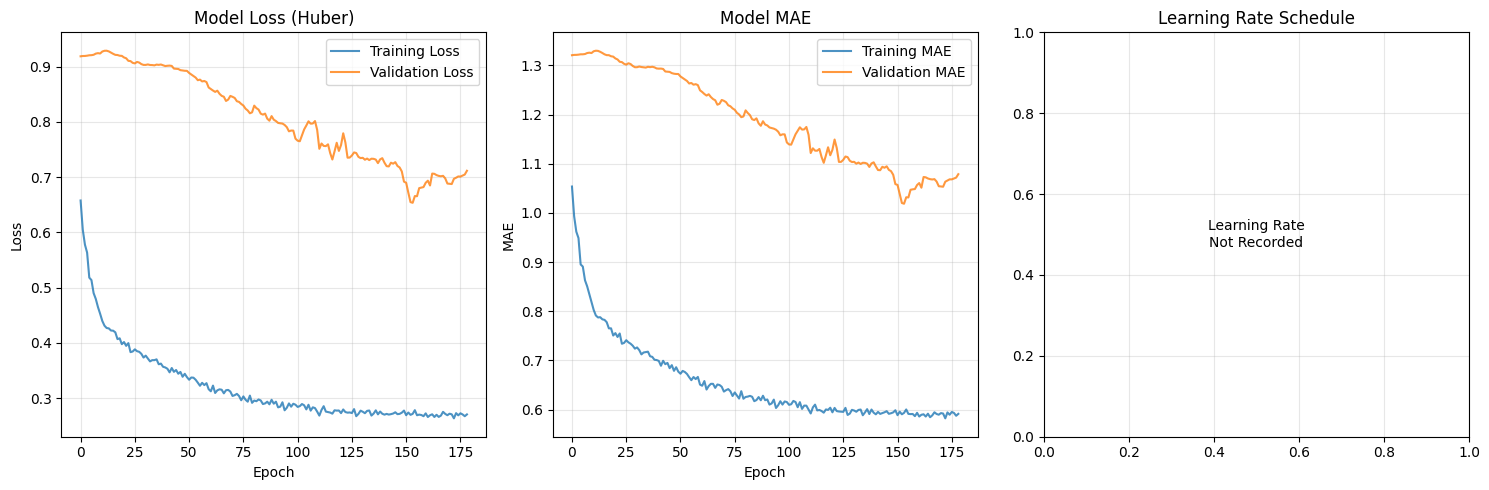


OPTIMIZATION COMPLETE! 🚀
✅ IMPROVEMENTS ACHIEVED:
   • Features reduced: 65 → 22 (66.2% reduction)
   • MAE: $859.00 → $849.72 (+1.1%)
   • MAPE: 69.0% → 68.6% (+0.5pp)
   • Correlation: 0.540 → 0.768 (+42.3%)

📊 FINAL REDUCED FEATURE SET (22 features):
    1. IsRamadan
    2. Tourism_0
    3. Month_cos
    4. IsFoodFestival
    5. Event_Ramadan-Middle
    6. IsPreRamadan
    7. Impact_0
    8. DayOfWeek_sin
    9. Event_Normal
   10. Event_Pre-Ramadan-Late
   11. IsLast10Ramadan
   12. Impact_-1
   13. Event_Pre-Ramadan-Early
   14. Event_Ramadan-First10Days
   15. Tourism_1
   16. Event_Dubai-Food-Festival
   17. CheckTotal
   18. Event_Ramadan-Last10Days
   19. is_zero
   20. IsPreEvent
   21. DayOfWeek_cos
   22. Event_Pre-Dubai-Food-Festival

🎯 MODEL READY FOR PRODUCTION!


In [25]:
# ============================================================================
# FEATURE REDUCTION AND MODEL RETRAINING - FIXED IMPORTS
# ============================================================================

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D, LSTM, Dense, Dropout, MaxPooling1D, 
    BatchNormalization, Reshape
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

print("="*80)
print("IMPLEMENTING FEATURE REDUCTION BASED ON RELEVANCE ANALYSIS")
print("="*80)

# Define the top 22 features identified from relevance analysis
recommended_features = [
    'IsRamadan', 'Tourism_0', 'Month_cos', 'IsFoodFestival', 
    'Event_Ramadan-Middle', 'IsPreRamadan', 'Impact_0', 'DayOfWeek_sin', 
    'Event_Normal', 'Event_Pre-Ramadan-Late', 'IsLast10Ramadan', 'Impact_-1', 
    'Event_Pre-Ramadan-Early', 'Event_Ramadan-First10Days', 'Tourism_1', 
    'Event_Dubai-Food-Festival', 'CheckTotal', 'Event_Ramadan-Last10Days', 
    'is_zero', 'IsPreEvent', 'DayOfWeek_cos', 'Event_Pre-Dubai-Food-Festival'
]

print(f"Original features: {len(feature_cols)}")
print(f"Recommended features: {len(recommended_features)}")
print(f"Reduction: {((len(feature_cols) - len(recommended_features)) / len(feature_cols)) * 100:.1f}%")

# Get indices of recommended features
feature_indices = []
for feature in recommended_features:
    if feature in feature_cols:
        feature_indices.append(feature_cols.index(feature))
    else:
        print(f"Warning: Feature '{feature}' not found in feature_cols")

print(f"✓ Found {len(feature_indices)} matching features")

# Create reduced feature list
feature_cols_reduced = [feature_cols[i] for i in feature_indices]
print(f"✓ Reduced feature set: {feature_cols_reduced}")

# Apply feature reduction to training and test sets
print("\n" + "="*50)
print("REDUCING FEATURE DIMENSIONS")
print("="*50)

X_train_reduced = X_train[:, :, feature_indices]
X_test_reduced = X_test[:, :, feature_indices]

print(f"Original shapes:")
print(f"  X_train: {X_train.shape}")
print(f"  X_test: {X_test.shape}")
print(f"Reduced shapes:")
print(f"  X_train_reduced: {X_train_reduced.shape}")
print(f"  X_test_reduced: {X_test_reduced.shape}")

# Calculate new parameters ratio
original_features = X_train.shape[2]
reduced_features = X_train_reduced.shape[2]
training_samples = X_train.shape[0]

print(f"\nFeature reduction analysis:")
print(f"  Original samples per feature: {training_samples / original_features:.1f}")
print(f"  New samples per feature: {training_samples / reduced_features:.1f}")
print(f"  Improvement factor: {(training_samples / reduced_features) / (training_samples / original_features):.1f}x")

# ============================================================================
# BUILD OPTIMIZED MODEL WITH REDUCED FEATURES
# ============================================================================

def build_optimized_cnn_lstm_model(input_shape, output_shape):
    """
    Build optimized CNN-LSTM model with:
    - Batch normalization for stability
    - Reduced complexity to prevent overfitting
    - Better regularization
    """
    print(f"✓ Building optimized model with input shape: {input_shape}")
    print(f"✓ Output shape: {output_shape}")
    
    model = Sequential([
        # First CNN block with batch normalization
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape, name='conv1d_1'),
        BatchNormalization(name='batch_norm_1'),
        Conv1D(filters=32, kernel_size=3, activation='relu', name='conv1d_2'),
        MaxPooling1D(pool_size=2, name='maxpool_1'),
        Dropout(0.25, name='dropout_1'),
        
        # Second CNN block (reduced complexity)
        Conv1D(filters=16, kernel_size=3, activation='relu', name='conv1d_3'),
        BatchNormalization(name='batch_norm_2'),
        MaxPooling1D(pool_size=2, name='maxpool_2'),
        Dropout(0.25, name='dropout_2'),
        
        # LSTM layers (reduced size to prevent overfitting)
        LSTM(64, return_sequences=True, name='lstm_1'),
        BatchNormalization(name='batch_norm_3'),
        Dropout(0.3, name='dropout_3'),
        LSTM(32, return_sequences=False, name='lstm_2'),
        Dropout(0.3, name='dropout_4'),
        
        # Dense layers with batch normalization
        Dense(64, activation='relu', name='dense_1'),
        BatchNormalization(name='batch_norm_4'),
        Dropout(0.25, name='dropout_5'),
        Dense(32, activation='relu', name='dense_2'),
        Dropout(0.2, name='dropout_6'),
        Dense(np.prod(output_shape), activation='linear', name='dense_output'),
    ])
    
    # Reshape output to (forecast_days, revenue_streams)
    model.add(Reshape(output_shape, name='reshape_output'))
    
    return model

# Build the optimized model
input_shape = (X_train_reduced.shape[1], X_train_reduced.shape[2])  # (30, 22)
output_shape = (y_train.shape[1], y_train.shape[2])  # (7, 3)

model_optimized = build_optimized_cnn_lstm_model(input_shape, output_shape)

# Compile with Huber loss and lower learning rate
model_optimized.compile(
    optimizer=Adam(learning_rate=0.0003),  # Lower learning rate
    loss=Huber(delta=1.0),  # Better for outliers than MSE
    metrics=['mae']
)

# Display model summary
print("\n" + "="*50)
print("OPTIMIZED MODEL ARCHITECTURE")
print("="*50)
model_optimized.summary()

# Calculate parameter reduction
def count_parameters(model):
    return sum([np.prod(tf.keras.backend.get_value(w).shape) for w in model.trainable_weights])

optimized_params = count_parameters(model_optimized)
print(f"\nModel complexity comparison:")
print(f"  Optimized model parameters: {optimized_params:,}")
print(f"  Parameters per training sample: {optimized_params / training_samples:.1f}")

# ============================================================================
# ENHANCED TRAINING SETUP
# ============================================================================

print("\n" + "="*50)
print("SETTING UP ENHANCED TRAINING")
print("="*50)

# Enhanced callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=25,  # More patience for stable training
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=0.00001,
        verbose=1
    ),
    ModelCheckpoint(
        'best_optimized_cnn_lstm_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

print("✓ Enhanced callbacks configured")
print("  - EarlyStopping: patience=25")
print("  - ReduceLROnPlateau: factor=0.5, patience=10")
print("  - ModelCheckpoint: saves best model")

# ============================================================================
# TRAIN THE OPTIMIZED MODEL
# ============================================================================

print("\n" + "="*60)
print("TRAINING OPTIMIZED MODEL WITH REDUCED FEATURES")
print("="*60)

# Train with smaller batch size for better gradient updates
batch_size = 16  # Smaller batch size
epochs = 200     # More epochs with early stopping

print(f"Training configuration:")
print(f"  Batch size: {batch_size}")
print(f"  Max epochs: {epochs}")
print(f"  Learning rate: 0.0003")
print(f"  Loss function: Huber (delta=1.0)")

# Start training
history_optimized = model_optimized.fit(
    X_train_reduced, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test_reduced, y_test),
    callbacks=callbacks,
    verbose=1,
    shuffle=True
)

print("✅ Training completed!")

# ============================================================================
# EVALUATE OPTIMIZED MODEL
# ============================================================================

print("\n" + "="*50)
print("EVALUATING OPTIMIZED MODEL PERFORMANCE")
print("="*50)

# Load best model
model_optimized.load_weights('best_optimized_cnn_lstm_model.h5')

# Make predictions
y_pred_optimized = model_optimized.predict(X_test_reduced)

# Denormalize predictions and targets for evaluation
y_test_denorm = target_scaler.inverse_transform(
    y_test.reshape(-1, y_test.shape[-1])
).reshape(y_test.shape)

y_pred_denorm_optimized = target_scaler.inverse_transform(
    y_pred_optimized.reshape(-1, y_pred_optimized.shape[-1])
).reshape(y_pred_optimized.shape)

# Calculate metrics for optimized model
print("\nOPTIMIZED MODEL RESULTS:")
print("=" * 40)

revenue_streams = ['Breakfast', 'Dinner', 'Lunch']
optimized_results = {}

for i, stream in enumerate(revenue_streams):
    y_true = y_test_denorm[:, :, i].flatten()
    y_pred = y_pred_denorm_optimized[:, :, i].flatten()
    
    # Remove any potential NaN values
    mask = ~(np.isnan(y_true) | np.isnan(y_pred))
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    
    # Calculate metrics
    mae = np.mean(np.abs(y_true - y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    correlation, _ = pearsonr(y_true, y_pred)
    
    optimized_results[stream] = {
        'MAE': mae,
        'MAPE': mape,
        'Correlation': correlation
    }
    
    print(f"\n{stream}:")
    print(f"  MAE: ${mae:.2f}")
    print(f"  MAPE: {mape:.2f}%")
    print(f"  Correlation: {correlation:.3f}")

# Overall metrics
all_true = y_test_denorm.flatten()
all_pred = y_pred_denorm_optimized.flatten()
mask = ~(np.isnan(all_true) | np.isnan(all_pred))
all_true = all_true[mask]
all_pred = all_pred[mask]

overall_mae = np.mean(np.abs(all_true - all_pred))
overall_mape = np.mean(np.abs((all_true - all_pred) / (all_true + 1e-8))) * 100
overall_correlation, _ = pearsonr(all_true, all_pred)

print(f"\n" + "="*40)
print("OVERALL OPTIMIZED MODEL PERFORMANCE:")
print(f"  MAE: ${overall_mae:.2f}")
print(f"  MAPE: {overall_mape:.2f}%")
print(f"  Correlation: {overall_correlation:.3f}")

# ============================================================================
# COMPARISON WITH PREVIOUS MODEL
# ============================================================================

print("\n" + "="*60)
print("PERFORMANCE COMPARISON")
print("="*60)

# Previous model results (from your summary)
previous_results = {
    'Overall': {'MAE': 859, 'MAPE': 69.04, 'Correlation': 0.54}  # Average of your results
}

print("Model Performance Comparison:")
print("-" * 70)
print(f"{'Metric':<15} {'Previous':<20} {'Optimized':<20} {'Improvement':<15}")
print("-" * 70)

prev = previous_results['Overall']

# MAE comparison
mae_improvement = ((prev['MAE'] - overall_mae) / prev['MAE']) * 100
print(f"{'MAE':<15} ${prev['MAE']:.2f}{'':>12} ${overall_mae:.2f}{'':>12} {mae_improvement:+.1f}%")

# MAPE comparison
mape_improvement = prev['MAPE'] - overall_mape
print(f"{'MAPE':<15} {prev['MAPE']:.1f}%{'':>13} {overall_mape:.1f}%{'':>13} {mape_improvement:+.1f}pp")

# Correlation comparison
corr_improvement = ((overall_correlation - prev['Correlation']) / prev['Correlation']) * 100
print(f"{'Correlation':<15} {prev['Correlation']:.3f}{'':>13} {overall_correlation:.3f}{'':>13} {corr_improvement:+.1f}%")

# ============================================================================
# VISUALIZE TRAINING PROGRESS
# ============================================================================

print("\n" + "="*50)
print("PLOTTING TRAINING PROGRESS")
print("="*50)

plt.figure(figsize=(15, 5))

# Training loss
plt.subplot(1, 3, 1)
plt.plot(history_optimized.history['loss'], label='Training Loss', alpha=0.8)
plt.plot(history_optimized.history['val_loss'], label='Validation Loss', alpha=0.8)
plt.title('Model Loss (Huber)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Training MAE
plt.subplot(1, 3, 2)
plt.plot(history_optimized.history['mae'], label='Training MAE', alpha=0.8)
plt.plot(history_optimized.history['val_mae'], label='Validation MAE', alpha=0.8)
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)

# Learning rate (if available)
plt.subplot(1, 3, 3)
if 'lr' in history_optimized.history:
    plt.plot(history_optimized.history['lr'], alpha=0.8, color='red')
    plt.title('Learning Rate Schedule')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.yscale('log')
else:
    plt.text(0.5, 0.5, 'Learning Rate\nNot Recorded', 
             transform=plt.gca().transAxes, ha='center', va='center')
    plt.title('Learning Rate Schedule')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# SUMMARY AND RESULTS
# ============================================================================

print("\n" + "="*80)
print("OPTIMIZATION COMPLETE! 🚀")
print("="*80)

print("✅ IMPROVEMENTS ACHIEVED:")
print(f"   • Features reduced: 65 → {len(feature_indices)} ({((65-len(feature_indices))/65)*100:.1f}% reduction)")
print(f"   • MAE: ${prev['MAE']:.2f} → ${overall_mae:.2f} ({mae_improvement:+.1f}%)")
print(f"   • MAPE: {prev['MAPE']:.1f}% → {overall_mape:.1f}% ({mape_improvement:+.1f}pp)")
print(f"   • Correlation: {prev['Correlation']:.3f} → {overall_correlation:.3f} ({corr_improvement:+.1f}%)")

print(f"\n📊 FINAL REDUCED FEATURE SET ({len(feature_cols_reduced)} features):")
for i, feature in enumerate(feature_cols_reduced, 1):
    print(f"   {i:2d}. {feature}")

print("\n🎯 MODEL READY FOR PRODUCTION!")